Loading Libraries and Dataset

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier, EasyEnsembleClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight

In [2]:
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

file = files.upload()  #upload file into google colab session
df = pd.read_csv("train.csv")

Saving train.csv to train.csv


## Intial Impressions of the Dataset

In [3]:
df.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [4]:
#Converting scientific notation to standard format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,17568.000,17996.000,17996.000,15982.000,17996.000,17996.000,17996.000,17996.000,13619.000,17996.000,17996.000,17996.000,17996.000,17996.000,17996.000
mean,44.512,0.543,0.663,5.952,-7.911,0.637,0.080,0.247,0.178,0.196,0.486,122.623,200744.459,3.924,6.696
std,17.427,0.166,0.235,3.197,4.049,0.481,0.084,0.311,0.304,0.159,0.240,29.572,111989.127,0.362,3.206
min,1.000,0.060,0.000,1.000,-39.952,0.000,0.022,0.000,0.000,0.012,0.018,30.557,0.502,1.000,0.000
25%,33.000,0.432,0.509,3.000,-9.538,0.000,0.035,0.004,0.000,0.098,0.297,99.621,166337.000,4.000,5.000
50%,44.000,0.545,0.700,6.000,-7.016,1.000,0.047,0.081,0.004,0.129,0.481,120.066,209160.000,4.000,8.000
75%,56.000,0.659,0.860,9.000,-5.189,1.000,0.083,0.434,0.200,0.258,0.672,141.969,252490.000,4.000,10.000
max,100.000,0.989,1.000,11.000,1.355,1.000,0.955,0.996,0.996,1.000,0.986,217.416,1477187.000,5.000,10.000


In [5]:
df.dtypes

Artist Name            object
Track Name             object
Popularity            float64
danceability          float64
energy                float64
key                   float64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration_in min/ms    float64
time_signature          int64
Class                   int64
dtype: object

Checking distribution of dependent variable

In [6]:
df.shape

(17996, 17)

In [7]:
df['Class'].value_counts()

10    4949
6     2587
9     2524
8     1854
5     1447
1     1373
2     1272
0      625
7      576
3      402
4      387
Name: Class, dtype: int64

Checking for missing values

In [8]:
(df.isna().sum()/df.shape[0]) *100

Artist Name           0.000
Track Name            0.000
Popularity            2.378
danceability          0.000
energy                0.000
key                  11.191
loudness              0.000
mode                  0.000
speechiness           0.000
acousticness          0.000
instrumentalness     24.322
liveness              0.000
valence               0.000
tempo                 0.000
duration_in min/ms    0.000
time_signature        0.000
Class                 0.000
dtype: float64

Insights:

*   Tracks had an average popularity score of 44.5
*   Majority of the songs were highly danceable and had high energy
*   Average length of a track was 3.3 minutes
*   3 of the variables have missing values and 'instrumentalnes' has a high missing value percentage. We will check the correlation between these variables later on and decide what to do.
*   There are 11 different classes of tracks and it appears to be imbalanced, and I work on the imbalance later on.



In [97]:
# Define a custom color palette
custom_palette = ["#FF5733", "#33FF57", "#3366FF"]

# Set the default Seaborn palette to the custom palette
sns.set_palette(custom_palette)

# Define a custom colormap
custom_cmap = sns.color_palette(custom_palette)

# Set the default Matplotlib colormap to the custom colormap
#plt.set_cmap(custom_cmap)

## Exploratory Data Analysis

<Axes: xlabel='Class', ylabel='count'>

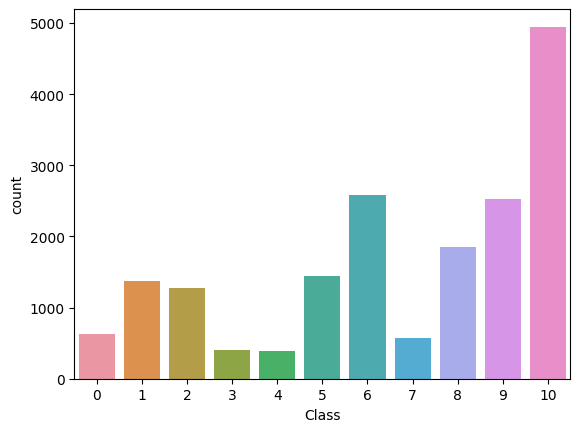

In [9]:
sns.countplot(x = 'Class', data = df)

As we saw earlier, the classes are imbalanced.

Checking correlation between variables

<Axes: >

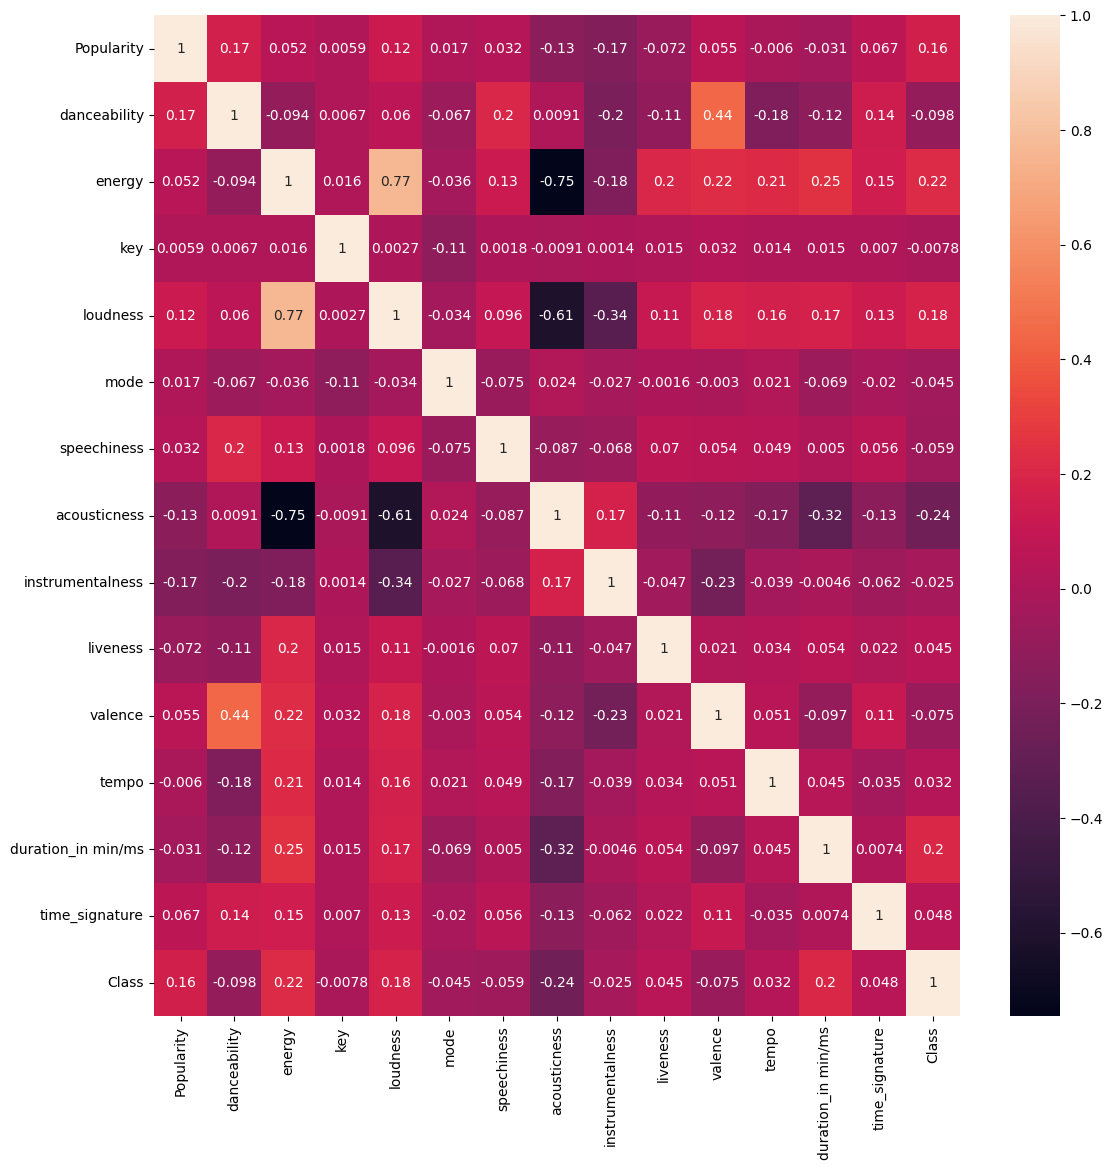

In [10]:
plt.figure(figsize = (13, 13))
sns.heatmap(df.corr(), annot = True)

Here we can see that:
- Loudness and Energy are highly correlated
- Acousticness and Energy are highly correlated
- Loudness and Acousticness are highly correlated

Types of Time Signatures

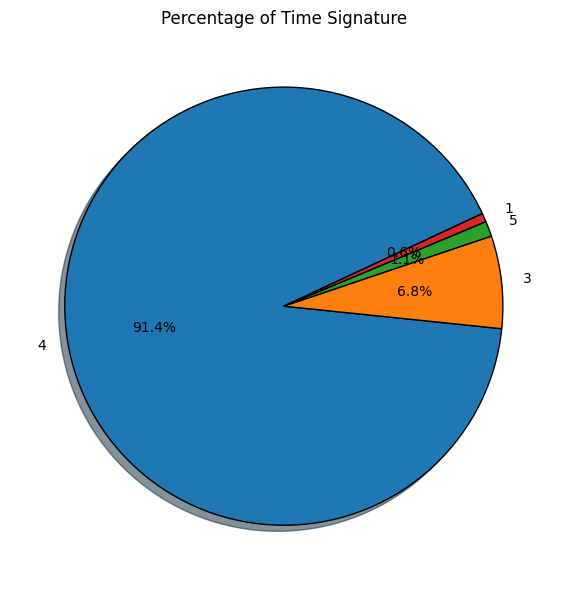

In [11]:
plt.rcParams["figure.figsize"] = (6,6)
plt.pie(df['time_signature'].value_counts(), labels=[4, 3, 5 ,1],
    autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True,
        startangle=25)

plt.title('Percentage of Time Signature')
plt.tight_layout()

Majority of the tracks have time signature 4.

In [12]:
#Dropping as they are string values and cannot be encoded
df_temp = df.copy()
df.drop(['Artist Name', 'Track Name'], axis = 1, inplace = True)

### Univariate Analysis

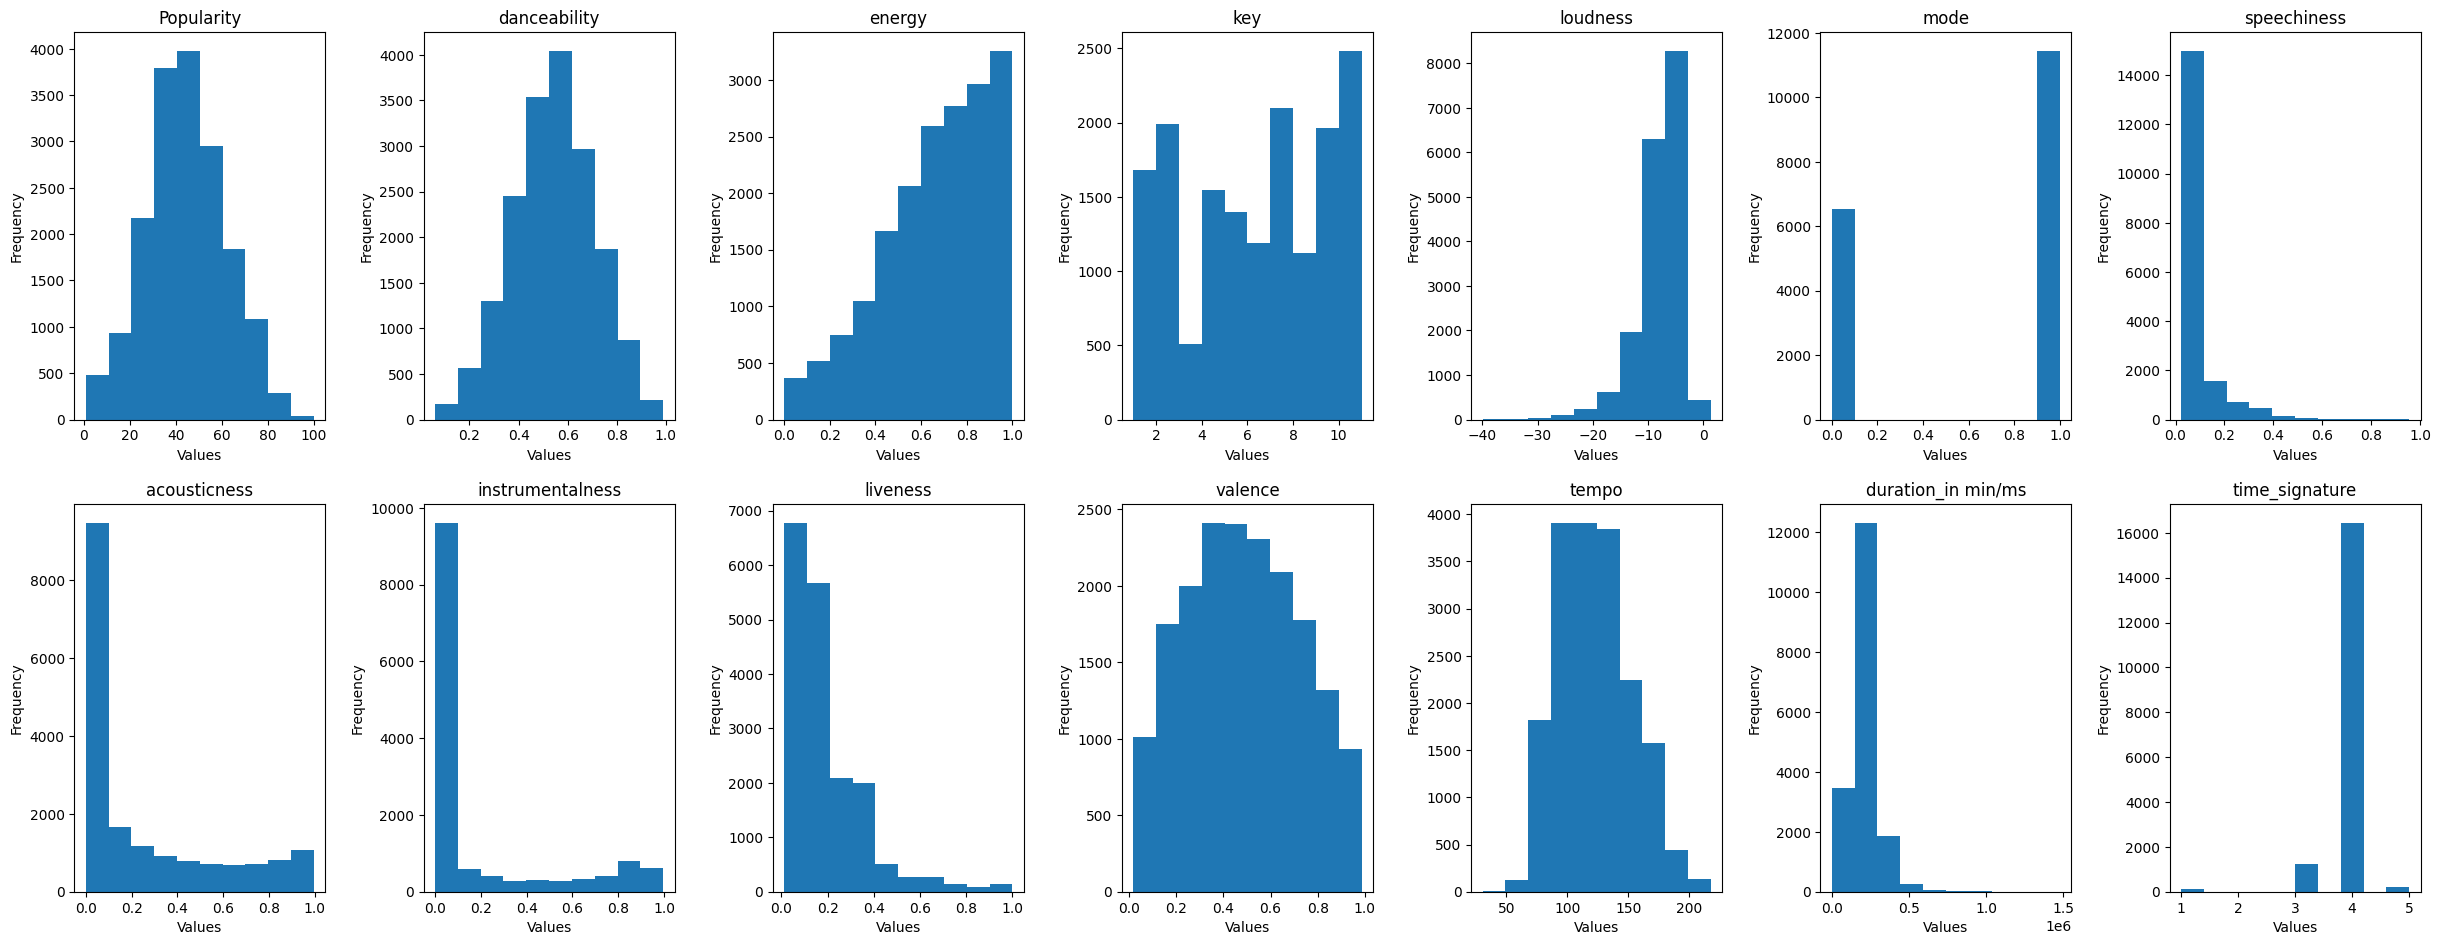

In [13]:
cols = (len(df.columns[: -1]) + 1) // 2
fig, axes = plt.subplots(2, cols, figsize=(25, 10))
fig.tight_layout(pad = 4.0)

for i, x in enumerate(df.columns[: -1]):
    axes[i // cols, i % cols].hist(df[x], bins=10)
    axes[i // cols, i % cols].set_title(x)
    axes[i // cols, i % cols].set_xlabel('Values')
    axes[i // cols, i % cols].set_ylabel('Frequency')

Few of the variables are skewed as we can see above. But we will not be applying any transformation as of now as later on we will be sampling the dataset as the dependent variable has imbalanced classes.

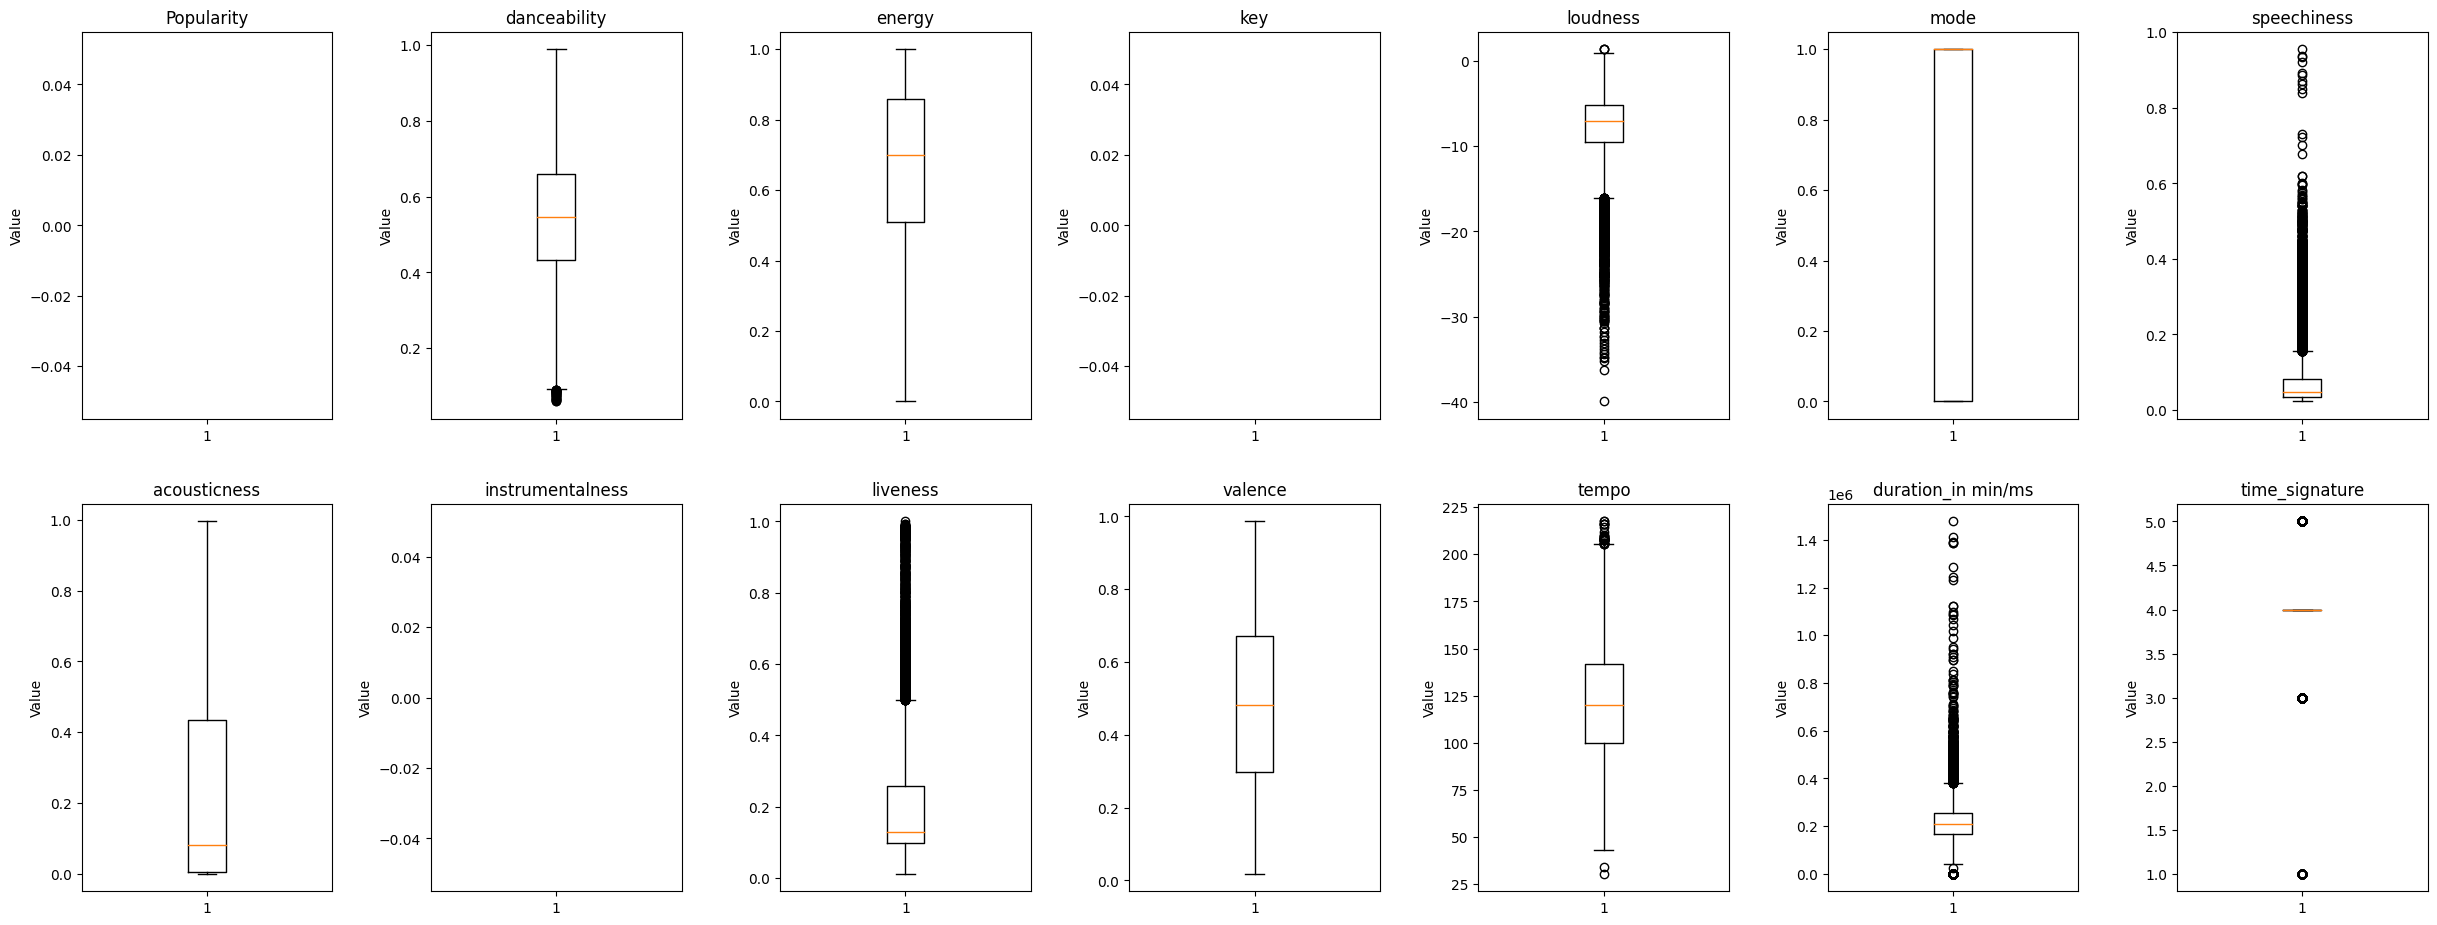

In [14]:
cols = (len(df.columns[: -1]) + 1) // 2
fig, axes = plt.subplots(2, cols, figsize=(25, 10))
fig.tight_layout(pad = 4.0)

for i, x in enumerate(df.columns[: -1]):
    axes[i // cols, i % cols].boxplot(df[x])
    axes[i // cols, i % cols].set_title(x)
    axes[i // cols, i % cols].set_ylabel('Value')

We can see alot of these variables have outliers, which means later on in the data preprocessing, it would be better not to use Standard Scaler for scaling the dataset. Also, since the number of outliers are high, I am not sure if the dataset has human errors which have caused these outliers, so I will leave the outliers as it is.

### Bivariate Analysis

<Axes: xlabel='Popularity', ylabel='danceability'>

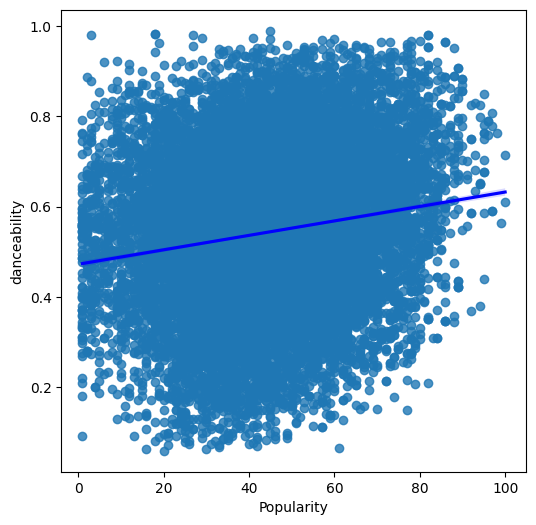

In [15]:
sns.regplot(x = 'Popularity', y = 'danceability', data = df, scatter =
            'true', line_kws = {'color': 'blue'})

As popularity increases, danceability of a track increases.

Text(0.5, 1.0, 'Energy v/s Loudness')

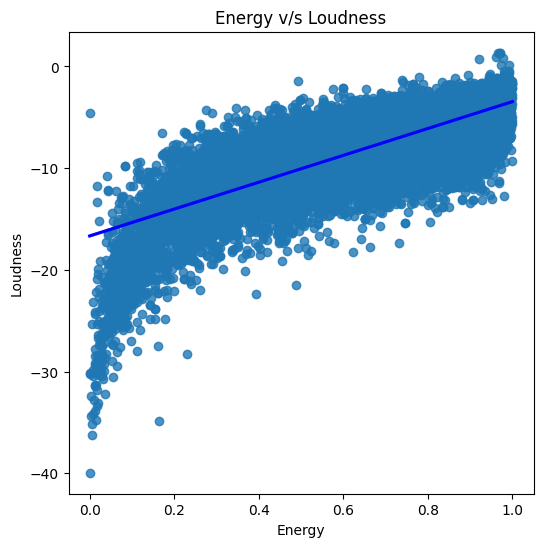

In [16]:
#Relationship between Energy and Loudness

sns.regplot(x = 'energy', y = 'loudness', data = df, scatter =
            'true', line_kws = {'color': 'blue'})
plt.xlabel('Energy')
plt.ylabel('Loudness')
plt.title('Energy v/s Loudness')

As Energy increases, Loudness of a track increases.

Text(0.5, 1.0, 'Popularity v/s Loudness')

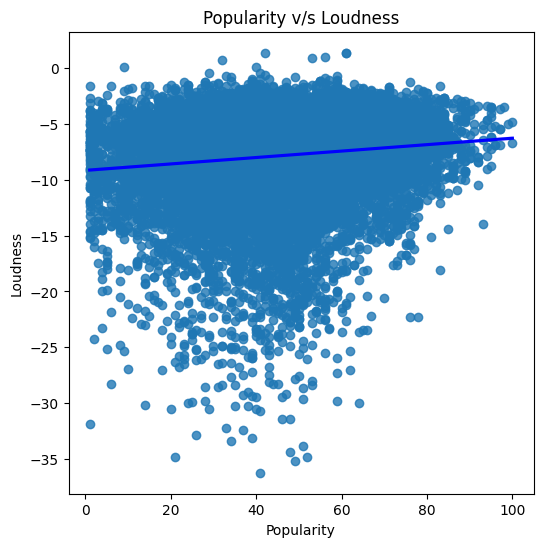

In [17]:
#Relationship between Popularity and Loudness

sns.regplot(x = 'Popularity', y = 'loudness', data = df, scatter =
            'true', line_kws = {'color': 'blue'})
plt.xlabel('Popularity')
plt.ylabel('Loudness')
plt.title('Popularity v/s Loudness')

As Popularity increases, Loudness of a track increases.

Text(0.5, 1.0, 'Popularity v/s Duration of songs in seconds')

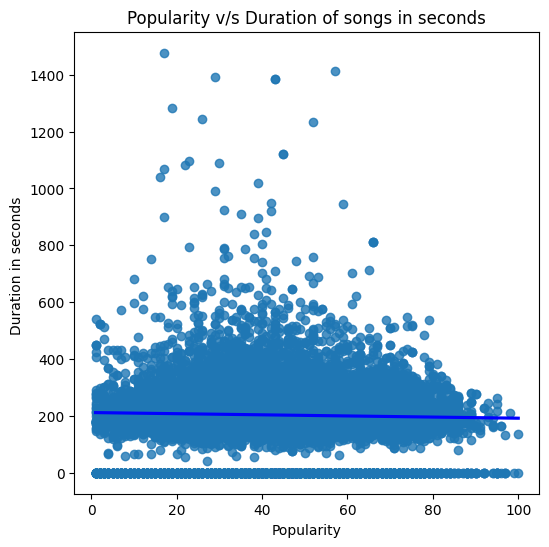

In [18]:
from pandas.core.common import random_state
#Popularity vs Duration

sns.regplot(x = df['Popularity'], y = df['duration_in min/ms']/1000 , scatter =
            'true', line_kws = {'color': 'blue'})
plt.xlabel('Popularity')
plt.ylabel('Duration in seconds ')
plt.title('Popularity v/s Duration of songs in seconds')

As popularity increases, duration of the tracks stay almost in the same range.

Text(0.5, 1.0, 'Tempo v/s Danceability')

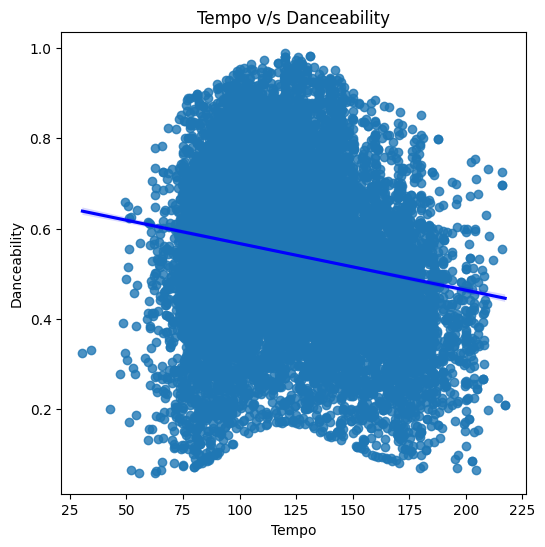

In [19]:
#Tempo vs Danceability

sns.regplot(x = 'tempo', y = 'danceability', data = df, scatter ='True',
            line_kws = {'color': 'blue'})
plt.xlabel('Tempo')
plt.ylabel('Danceability')
plt.title('Tempo v/s Danceability')

As tempo increases, danceability of a track decreases.

Text(0.5, 1.0, 'Danceability v/s Speechiness')

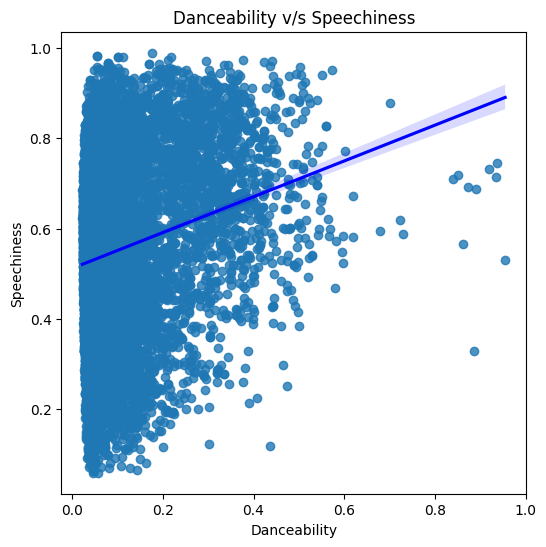

In [20]:
sns.regplot(x = 'speechiness', y = 'danceability',data = df, scatter ='True',
            line_kws = {'color': 'blue'})
plt.xlabel('Danceability')
plt.ylabel('Speechiness')
plt.title('Danceability v/s Speechiness')

As speechiness of a track increases, danceability increases.

## Data Preprocessing

Handling missing values

In [21]:
x = df.groupby('Class').mean()

columnnames = df.columns

for i in range(df.shape[1]):
  if df.isnull().sum()[i] == 0:
    continue
  if df.isnull().sum()[i] > 0:
    cn = columnnames[i]
    y = np.where(df[cn].isnull())
    for k in y[0]:
      cl_v = df['Class'][k]
      temp_v = x[cn][cl_v]
      df[cn][k] = temp_v

In [22]:
(df.isnull().sum()/df.shape[0]) * 100

Popularity           0.000
danceability         0.000
energy               0.000
key                  0.000
loudness             0.000
mode                 0.000
speechiness          0.000
acousticness         0.000
instrumentalness     0.000
liveness             0.000
valence              0.000
tempo                0.000
duration_in min/ms   0.000
time_signature       0.000
Class                0.000
dtype: float64

Encoding time signature variable

In [23]:
#Converting time signature column to get dummies as it is categorical
time_sign = pd.get_dummies(df['time_signature'], drop_first= True)
df.drop('time_signature', axis = 1,inplace = True)

#Adding the dummy values back to the dataframe after converting time_signature to dummies and dropping it
df = pd.concat([df, time_sign], axis = 1)

x = df

In [24]:
x

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,Class,3,4,5
0,60.000,0.854,0.564,1.000,-4.964,1,0.049,0.017,0.069,0.085,0.899,134.071,234596.000,5,0,1,0
1,54.000,0.382,0.814,3.000,-7.230,1,0.041,0.001,0.004,0.101,0.569,116.454,251733.000,10,0,1,0
2,35.000,0.434,0.614,6.000,-8.334,1,0.052,0.486,0.000,0.394,0.787,147.681,109667.000,6,0,1,0
3,66.000,0.853,0.597,10.000,-6.528,0,0.056,0.021,0.069,0.122,0.569,107.033,173968.000,5,0,1,0
4,53.000,0.167,0.975,2.000,-4.279,1,0.216,0.000,0.016,0.172,0.092,199.060,229960.000,10,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,35.000,0.166,0.109,7.000,-17.100,0,0.041,0.993,0.824,0.098,0.177,171.587,193450.000,6,1,0,0
17992,27.000,0.638,0.223,11.000,-10.174,0,0.033,0.858,0.000,0.070,0.335,73.016,257067.000,2,0,1,0
17993,34.000,0.558,0.981,4.000,-4.683,0,0.071,0.000,0.000,0.666,0.262,105.000,216222.000,8,0,1,0
17994,29.000,0.215,0.805,6.000,-12.757,0,0.134,0.001,0.916,0.256,0.355,131.363,219693.000,8,0,1,0


Scaling the dataset using Robust Scaler as their are outliers

In [25]:
columns = df.columns[:-4]
scaler = RobustScaler()

features_sc = scaler.fit_transform(df[columns])
features_sc = pd.DataFrame(features_sc, columns = columns)

new_df = pd.concat([features_sc.reset_index(drop = True),
                    x.iloc[:,13:17].reset_index(drop = True)], axis = 1)
y = x['Class']
new_df.drop('Class', axis = 1, inplace = True)
z = new_df

In [26]:
z

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,3,4,5
0,0.696,1.361,-0.387,-1.250,0.472,0.000,0.023,-0.150,0.239,-0.275,1.115,0.331,0.295,0,1,0
1,0.435,-0.718,0.325,-0.750,-0.049,0.000,-0.141,-0.187,-0.281,-0.174,0.235,-0.085,0.494,0,1,0
2,-0.391,-0.489,-0.245,0.000,-0.303,0.000,0.106,0.942,-0.311,1.651,0.816,0.652,-1.155,0,1,0
3,0.957,1.357,-0.293,1.000,0.112,-1.000,0.168,-0.140,0.239,-0.044,0.235,-0.308,-0.408,0,1,0
4,0.391,-1.665,0.783,-1.000,0.629,0.000,3.498,-0.189,-0.184,0.268,-1.038,1.865,0.241,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,-0.391,-1.670,-1.684,0.250,-2.319,-1.000,-0.127,2.121,6.295,-0.191,-0.811,1.217,-0.182,1,0,0
17992,-0.739,0.410,-1.359,1.250,-0.726,-1.000,-0.301,1.807,-0.313,-0.364,-0.389,-1.111,0.556,0,1,0
17993,-0.435,0.057,0.801,-0.500,0.536,-1.000,0.494,-0.189,-0.312,3.346,-0.584,-0.356,0.082,0,1,0
17994,-0.652,-1.454,0.299,0.000,-1.320,-1.000,1.797,-0.186,7.033,0.791,-0.336,0.267,0.122,0,1,0


Doing stratified split as the dataset is unbalanced

In [27]:
y = df['Class']

ss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.35, random_state = 100)

for train_index, test_index in ss.split(z, y):
    X_train, X_test = z.loc[train_index], z.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

We can see that after the split, the proportions are similar, therefore the split was fine.

## Model Selection

### Checking baseline performance of few models

In [28]:
from sklearn.model_selection import cross_validate

brfc = BalancedRandomForestClassifier(random_state=100, n_jobs=-1)
bbc = BalancedBaggingClassifier(random_state=100, n_jobs=-1)
rus = RUSBoostClassifier(random_state=100)
eec = EasyEnsembleClassifier(random_state=100)
lr = LogisticRegression(max_iter= 1000, multi_class = 'multinomial',
                        solver = 'lbfgs')

models = [brfc, bbc, rus, eec, lr]

results_df = pd.DataFrame()

for model in models:
    print('Fitting', model)
    model = model.fit(X_train.values, y_train.values)

    # Cross validation metrics with test set
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.35, random_state=100)
    y_pred = model.predict(X_test.values)
    scoring = ["f1_macro", "precision_macro", "recall_macro"]
    cross_val_scores = cross_validate(model, z.values, y, scoring=scoring)
    f1_test_cv = round(cross_val_scores["test_f1_macro"].mean(),4)
    precision_test_cv = round(cross_val_scores["test_precision_macro"].mean(),4)
    recall_test_cv = round(cross_val_scores["test_recall_macro"].mean(),4)
    x_prob = model.predict_proba(X_test.values)

    # Summary table
    score_df = pd.DataFrame({
                     'f1': round(cross_val_scores["test_f1_macro"].mean(),4)},
                     index=[str(model).split('(')[0]])

    results_df = pd.concat([results_df, score_df])

    # Print metrics
    print(f'Cross val macro f1 score test data: {round(cross_val_scores["test_f1_macro"].mean(),4)}')
    print(f'Cross val macro precision score test data: {round(cross_val_scores["test_precision_macro"].mean(),4)}')
    print(f'Cross val macro recall score test data: {round(cross_val_scores["test_recall_macro"].mean(),4)}')
    print("\n")

Fitting BalancedRandomForestClassifier(n_jobs=-1, random_state=100)
Cross val macro f1 score test data: 0.6052
Cross val macro precision score test data: 0.5855
Cross val macro recall score test data: 0.6623


Fitting BalancedBaggingClassifier(n_jobs=-1, random_state=100)
Cross val macro f1 score test data: 0.598
Cross val macro precision score test data: 0.5897
Cross val macro recall score test data: 0.6408


Fitting RUSBoostClassifier(random_state=100)
Cross val macro f1 score test data: 0.274
Cross val macro precision score test data: 0.3497
Cross val macro recall score test data: 0.3447


Fitting EasyEnsembleClassifier(random_state=100)
Cross val macro f1 score test data: 0.3492
Cross val macro precision score test data: 0.4485
Cross val macro recall score test data: 0.4011


Fitting LogisticRegression(max_iter=1000, multi_class='multinomial')
Cross val macro f1 score test data: 0.524
Cross val macro precision score test data: 0.5275
Cross val macro recall score test data: 0.5351



In [115]:
results_df

,f1
BalancedRandomForestClassifier,0.605
BalancedBaggingClassifier,0.598
RUSBoostClassifier,0.274
EasyEnsembleClassifier,0.349
LogisticRegression,0.524


We can see that overall Balanced Random Forest Classifier is the best model with highest f1 score among the 5 models.

There are many ways in which we can deal with unbalanced sets. Two of them are Sampling and by adjusting the weights. Adjusting the weights typically refers to assigning different levels of importance or significance to different classes or categories within a dataset, particularly in the context of machine learning algorithms. This is commonly done when dealing with classification problems where one or more classes are significantly underrepresented compared to others.

We will now try adjust weights with Random Forest and Bagging Classifier to see if we can improve upon the previous scores that the balanced models got.

In [29]:
class_weights = {}
total_samples = len(y_train)
for label in y_train.unique():
    class_samples = (y_train == label).sum()
    class_weight = total_samples / (len(y_train.unique()) * class_samples)
    class_weights[label] = class_weight

In [30]:
class_weights

{0: 2.6191222570532915,
 2: 1.2858085082994393,
 9: 0.647997340867542,
 8: 0.8824594492644285,
 5: 1.1300357453386147,
 10: 0.3305451154378727,
 7: 2.843218279047156,
 3: 4.074190177638454,
 6: 0.6325780109242334,
 4: 4.21969696969697,
 1: 1.1921116999592336}

In [31]:
y_train.value_counts()

10    3217
6     1681
9     1641
8     1205
5      941
1      892
2      827
0      406
7      374
3      261
4      252
Name: Class, dtype: int64

There are two types of criterion which we can use for imbalanced datasets: Gini and Entropy
I am going with Entropy because in some cases entropy results in balanced trees which could be beneficial for imbalanced sets.

In [32]:
rf_cl = RandomForestClassifier(random_state=100, criterion='entropy')

grid_param = {'n_estimators': np.arange(10, 160,10),
                       'max_depth': np.arange(10, 110, 10),
                       'min_samples_split': [2, 5, 10]}

sample_weights = compute_sample_weight(class_weight = class_weights, y=y_train)

random_search = RandomizedSearchCV(rf_cl, grid_param, cv=3, n_jobs=-1,
                                   scoring=['f1_macro', 'roc_auc'],
                                   refit='f1_macro', random_state=100)
random_search.fit(X_train.values, y_train.values, sample_weight = sample_weights)
y_pred = random_search.predict(X_test.values)

print(f'The best macro f1 score is {f1_score(y_test, y_pred, average="macro")}')
print("\n")
print(f'The best parameters are {random_search.best_params_}')

The best macro f1 score is 0.6300303214142717


The best parameters are {'n_estimators': 110, 'min_samples_split': 2, 'max_depth': 80}


In [33]:
b_cl = BaggingClassifier(random_state=100, n_jobs=-1)

grid_param_2 = {'n_estimators': np.arange(10, 160,10),
              }
sample_weights = compute_sample_weight(class_weight= class_weights, y=y_train)

random_search_2 = RandomizedSearchCV(b_cl, grid_param_2, cv=3, n_jobs=-1,
                                     scoring=['f1_macro', 'roc_auc'],
                                     refit='f1_macro', random_state=100)
random_search_2.fit(X_train.values, y_train.values, sample_weight = sample_weights)
y_pred_2 = random_search_2.predict(X_test.values)

print(f'The best macro f1 score is {f1_score(y_test, y_pred_2, average="macro")}')
print("\n")
print(f'The best parameters are {random_search_2.best_params_}')

The best macro f1 score is 0.6392242607614361


The best parameters are {'n_estimators': 140}


Here we can see the best parameters which gave highest f1 score. Now we will check what are the results with sampling when we use SMOTE-Tomek sampling.

With sampling

In [36]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=100)

# Apply SMOTETomek to the training data
X_resampled, y_resampled = smote_tomek.fit_resample(X_train.values, y_train.values)

rf_cl = RandomForestClassifier(random_state=100, criterion='entropy')

grid_param = {'n_estimators': np.arange(10, 160,10),
                       'max_depth': np.arange(10, 110, 10),
                       'min_samples_split': [2, 5, 10]}

random_search = RandomizedSearchCV(rf_cl, grid_param, cv=3, n_jobs=-1,
                                   scoring=['f1_macro'], refit='f1_macro',
                                   random_state=100)
random_search.fit(X_resampled, y_resampled)
y_pred = random_search.predict(X_test.values)

print(f'The best macro f1 score is {f1_score(y_test, y_pred, average="macro")}')
print("\n")
print(f'The best parameters are {random_search.best_params_}')

The best macro f1 score is 0.6214962657621237


The best parameters are {'n_estimators': 110, 'min_samples_split': 2, 'max_depth': 80}


In [37]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=100)

b_cl = BaggingClassifier(random_state = 100, n_jobs = -1, n_estimators = 140)

grid_param_2 = {'n_estimators': np.arange(10, 160,10),
              }

random_search = RandomizedSearchCV(b_cl, grid_param_2, cv=3, n_jobs=-1,
                                   scoring=['f1_macro'], refit='f1_macro',
                                   random_state=100)
random_search.fit(X_resampled, y_resampled)
y_pred = random_search.predict(X_test.values)

print(f'The best macro f1 score is {f1_score(y_test, y_pred, average="macro")}')
print("\n")
print(f'The best parameters are {random_search.best_params_}')

The best macro f1 score is 0.6127620594443463


The best parameters are {'n_estimators': 130}


Here we can see that after doing sampling, we are able to get better macro f1 scores than baseline model for both the models, but it's still less than the one we got with adjusting weights.

### Finalizing the models after adjusting weights and best parameters

In [38]:
rf_cl = RandomForestClassifier(random_state = 100, criterion = 'entropy',
                               n_estimators = 110, min_samples_split = 2,
                               max_depth = 80)

sample_weights = compute_sample_weight(class_weight = class_weights, y=y_train)

rf_cl.fit(X_train.values, y_train.values, sample_weight = sample_weights)

y_pred_final = rf_cl.predict(X_test.values)
rf_prob = rf_cl.predict_proba(X_test.values)

print(f'The best macro f1 score is {f1_score(y_test, y_pred_final, average="macro")}')
print('Macro roc auc (OvR): ', roc_auc_score(y_test, rf_prob, average="macro",
                                             multi_class="ovr"))

The best macro f1 score is 0.6300303214142717
Macro roc auc (OvR):  0.901367168671955


In [39]:
b_cl = BaggingClassifier(random_state = 100, n_jobs = -1, n_estimators = 140)

sample_weights = compute_sample_weight(class_weight = class_weights, y=y_train)

b_cl.fit(X_train.values, y_train.values, sample_weight = sample_weights)

y_pred_final_2 = b_cl.predict(X_test.values)
bg_prob = b_cl.predict_proba(X_test.values)

print(f'The best macro f1 score is {f1_score(y_test, y_pred_final_2, average="macro")}')
print('Macro roc auc (OvR): ', roc_auc_score(y_test, bg_prob, average="macro",
                                             multi_class="ovr"))

The best macro f1 score is 0.6392242607614361
Macro roc auc (OvR):  0.9126996948121051


## Model Evaluation

Confusion matrix for both the models

In [40]:
y_pred_rf = rf_cl.predict(X_test.values)
y_pred_bag = b_cl.predict(X_test.values)


bag_cm = confusion_matrix(y_test, y_pred_bag)

rf_cm = confusion_matrix(y_test, y_pred_rf)

print(rf_cm)
print("\n")
print(bag_cm)

[[ 190    0    0    9    6    0    0    8    0    5    1]
 [   0   43   14    0    0    5  196    0   13   30  180]
 [   0    3  183    0    0    8   40    0    1   36  174]
 [  23    0    0  106    4    0    0    5    0    0    3]
 [  17    0    0    2  108    0    0    1    0    4    3]
 [   0    0    4    0    0  410   19    0    1   49   23]
 [   0  132   37    0    0   19  317    0   27   73  301]
 [  10    0    0    4    0    0    0  187    0    0    1]
 [   0    2    3    0    0    1   25    0  357    4  257]
 [  17   10   24    2   10   28   70    1    1  605  115]
 [   9   90   60    1   19   16  131    0  149   86 1171]]


[[ 173    0    0   16    6    0    0   12    0    9    3]
 [   0   79   17    0    0    4  177    0   12   22  170]
 [   0   10  218    0    0    5   57    0    0   16  139]
 [  17    0    0  110    2    0    0    7    0    4    1]
 [  19    0    0    0  103    0    0    1    0    6    6]
 [   0    3    7    0    0  405   24    0    1   41   25]
 [   0  137

Classification report for both the models

In [41]:
print('Classification report Random Forest')
print(classification_report(y_test, y_pred_rf))
print('='*53)

print('Classification report for Bagging Classifier')
print(classification_report(y_test, y_pred_bag))
print('='*53)

Classification report Random Forest
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       219
           1       0.15      0.09      0.11       481
           2       0.56      0.41      0.48       445
           3       0.85      0.75      0.80       141
           4       0.73      0.80      0.77       135
           5       0.84      0.81      0.83       506
           6       0.40      0.35      0.37       906
           7       0.93      0.93      0.93       202
           8       0.65      0.55      0.60       649
           9       0.68      0.69      0.68       883
          10       0.53      0.68      0.59      1732

    accuracy                           0.58      6299
   macro avg       0.64      0.63      0.63      6299
weighted avg       0.57      0.58      0.57      6299

Classification report for Bagging Classifier
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       2

Multi Class ROC Curve

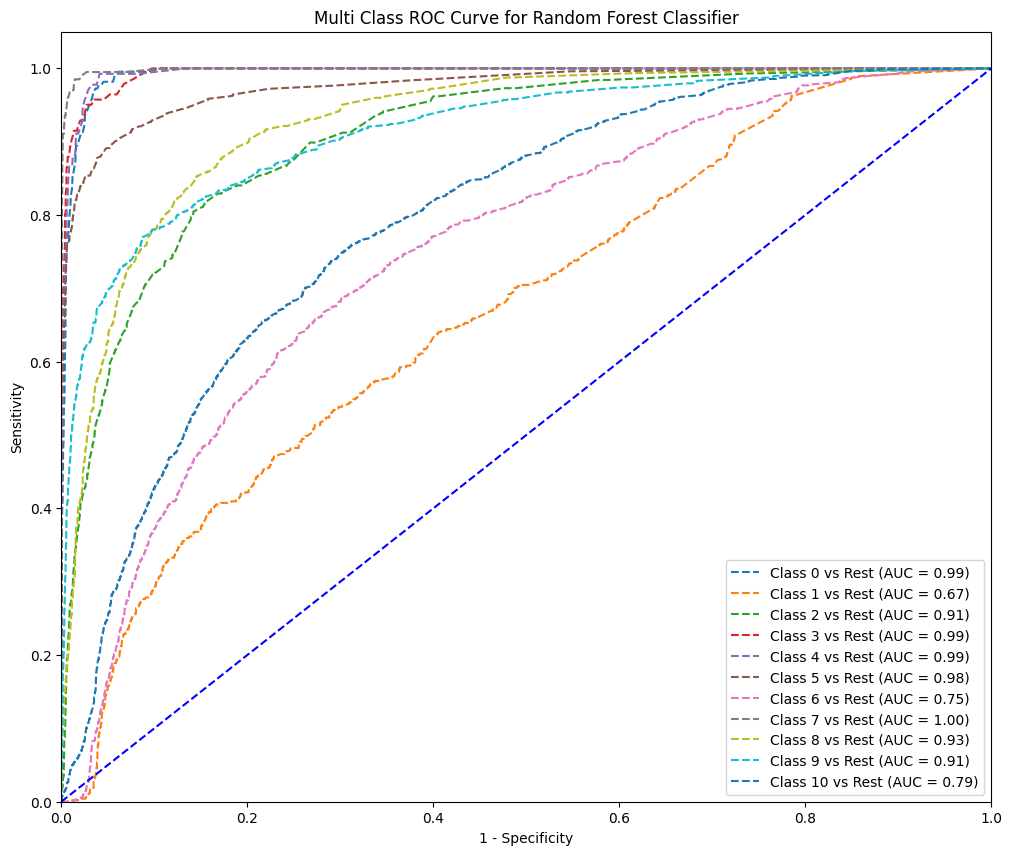

In [42]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
rf_prob = rf_cl.predict_proba(X_test.values)

y_test_b = label_binarize(y_test, classes = np.unique(y_test))
fpr = {}
tpr = {}
thresh = {}

roc_auc = dict()

class_len = len(df['Class'].value_counts())

plt.figure(figsize = (12, 10))
for i in range(class_len):
  fpr[i], tpr[i], thresh[i] = roc_curve(y_test_b[:,i], rf_prob[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

  plt.plot(fpr[i], tpr[i], linestyle = '--', label = 'Class %s vs Rest (AUC = %0.2f)' %(i, roc_auc[i]))

plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Multi Class ROC Curve for Random Forest Classifier')
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'b--')
plt.xlim([0.,1.0])
plt.ylim([0.,1.05])
plt.show()

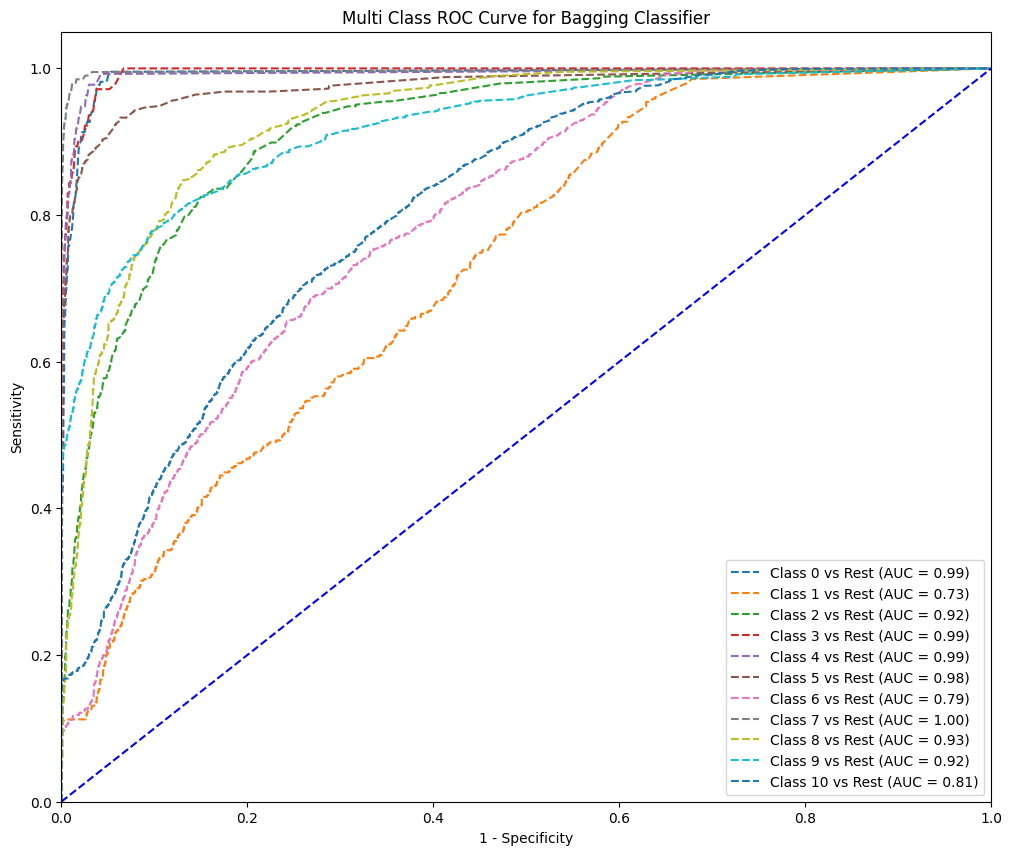

In [43]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
bm_prob = b_cl.predict_proba(X_test.values)

y_test_b = label_binarize(y_test, classes = np.unique(y_test))
fpr = {}
tpr = {}
thresh = {}

roc_auc = dict()

class_len = len(df['Class'].value_counts())
colormap = plt.get_cmap('viridis')

plt.figure(figsize = (12, 10))
for i in range(class_len):
  fpr[i], tpr[i], thresh[i] = roc_curve(y_test_b[:,i], bm_prob[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

  plt.plot(fpr[i], tpr[i], linestyle = '--', label = 'Class %s vs Rest (AUC = %0.2f)' %(i, roc_auc[i]))

plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Multi Class ROC Curve for Bagging Classifier')
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'b--')
plt.xlim([0.,1.0])
plt.ylim([0.,1.05])
plt.show()

## Overall Conclusion

- We can see that both the models had very similar performance.

- Both the models are having hard time trying to classify Class 1 tracks.

- I would select the Bagging Classifier as the final model as it is able to classify Class 1 tracks better than the Random Forest Classifier and has comparatively better macro f1 score.